
Loading and preparing data...

Applying SMOTE...

Starting optimized SVM training...

Phase 1: Coarse parameter search
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Phase 2: Focused parameter search
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Optimized training completed in 0.4 minutes
Best parameters: {'C': 13.763586964714708, 'gamma': 10.0, 'kernel': 'rbf'}
Best cross-validation AUC: 0.8017

PER-SAMPLE RESULTS

Test Set Performance (Per Sample):
Accuracy: 0.6370
ROC AUC: 0.5727

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.84      0.75       472
           1       0.48      0.27      0.35       258

    accuracy                           0.64       730
   macro avg       0.58      0.55      0.55       730
weighted avg       0.61      0.64      0.61       730



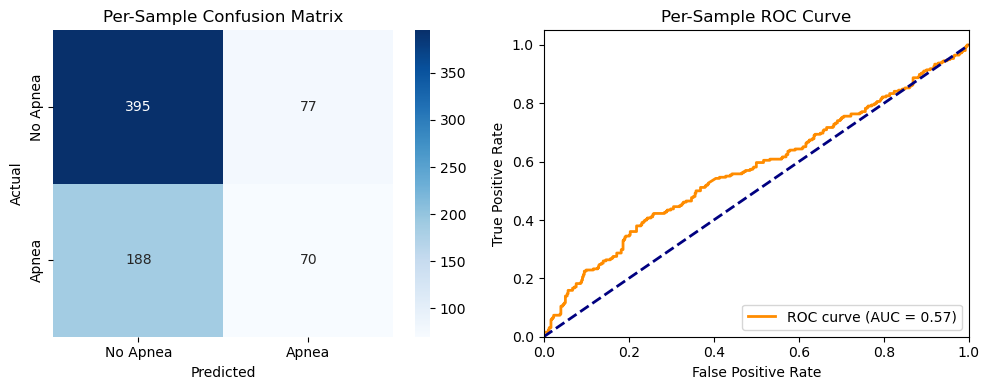


PER-PATIENT RESULTS

Optimal probability threshold: 0.3448

Patient-Level Performance:
Accuracy: 0.8000
ROC AUC: 0.6800


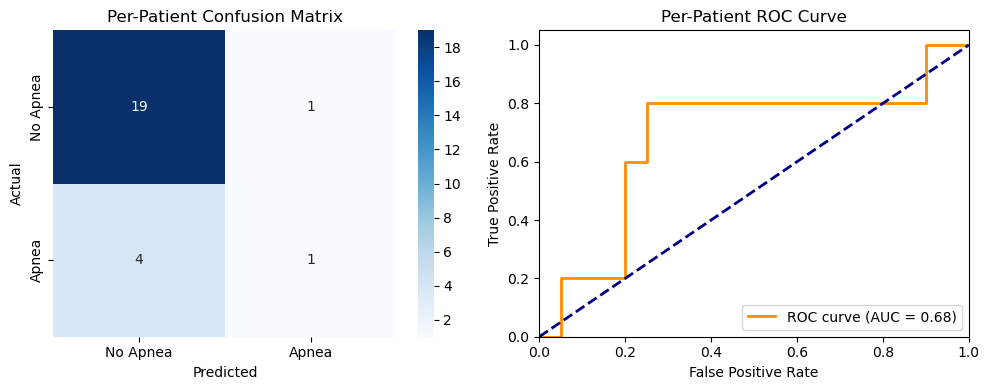


Detailed Patient Results with Optimal Threshold:
    patient_id  Apnea_Label  Predicted_Probability  Patient_Prediction
0            2            0               0.292611                   0
1            3            1               0.310075                   0
2            5            0               0.289716                   0
3            6            0               0.321212                   0
4            7            0               0.179746                   0
5            8            0               0.241849                   0
6            9            0               0.284420                   0
7           10            0               0.235720                   0
8           11            0               0.230350                   0
9           12            1               0.296171                   0
10          13            0               0.293803                   0
11          14            1               0.361482                   1
12          15            0

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats import loguniform
import time

# ========== LOAD AND PREPARE DATA ==========
print("\nLoading and preparing data...")

# Load data
data = pd.read_csv('labelled_ecg_features.csv')

# Include patient_id if available
features = ['patient_id', 'Mean RR Interval (ms)', 'Overall HRV', 'RMS_SD (ms)', 'pNN50 (%)', 
            'VLF Power', 'EDR Rate (breaths per min)', 'CVHR (%)']
X = data[features]
y = data['Apnea_Label']

# Handle NaNs
X = X.fillna(X.mean())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, stratify=y)

# Save patient IDs separately for later aggregation
test_patient_data = X_test[['patient_id']].copy()

# Scale features (exclude patient_id during scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop('patient_id', axis=1))
X_test_scaled = scaler.transform(X_test.drop('patient_id', axis=1))

# ========== SMOTE FOR BALANCING ==========
print("\nApplying SMOTE...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# ========== SVM TRAINING ==========
print("\nStarting optimized SVM training...")
start_time = time.time()

# --- Phase 1: Coarse Parameter Search ---
print("\nPhase 1: Coarse parameter search")
initial_params = {
    'C': loguniform(1e-2, 1e2),
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 1, 5)),
    'kernel': ['rbf', 'linear']
}

svm = SVC(probability=True, random_state=42)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    svm, initial_params, n_iter=20,
    cv=cv, scoring='roc_auc', 
    n_jobs=-1, random_state=42, verbose=1
)
random_search.fit(X_train_balanced, y_train_balanced)

# --- Phase 2: Focused Parameter Search ---
print("\nPhase 2: Focused parameter search")
best_params_phase1 = random_search.best_params_
refined_params = {
    'C': [best_params_phase1['C'] * x for x in [0.5, 1, 2]],
    'gamma': [best_params_phase1['gamma'] * x for x in [0.5, 1, 2]] if isinstance(best_params_phase1['gamma'], float) else ['scale', 'auto'],
    'kernel': [best_params_phase1['kernel']]
}

cv_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_search = GridSearchCV(
    svm, refined_params, 
    cv=cv_final, scoring='roc_auc',
    n_jobs=-1, verbose=1
)
final_search.fit(X_train_balanced, y_train_balanced)

# Get best model
best_svm = final_search.best_estimator_
print("\nOptimized training completed in %.1f minutes" % ((time.time() - start_time)/60))
print("Best parameters:", final_search.best_params_)
print("Best cross-validation AUC: %.4f" % final_search.best_score_)

# ========== PER-SAMPLE ANALYSIS ==========
print("\n" + "="*50)
print("PER-SAMPLE RESULTS")
print("="*50)

# Predictions on test set
y_pred = best_svm.predict(X_test_scaled)
y_prob = best_svm.predict_proba(X_test_scaled)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
print("\nTest Set Performance (Per Sample):")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['No Apnea', 'Apnea'], 
           yticklabels=['No Apnea', 'Apnea'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Per-Sample Confusion Matrix')

# ROC curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
        label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Per-Sample ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ========== PER-PATIENT ANALYSIS ==========
print("\n" + "="*50)
print("PER-PATIENT RESULTS")
print("="*50)

# Get optimal threshold from ROC curve (Youden's J statistic)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal probability threshold: {optimal_threshold:.4f}")

# Add predictions and probabilities to patient data
test_patient_data['Apnea_Label'] = y_test.values
test_patient_data['Predicted_Probability'] = y_prob

# Aggregate by patient
patient_results = test_patient_data.groupby('patient_id').agg({
    'Apnea_Label': lambda x: (x.mean() > 0.5).astype(int),  # Majority vote for apnea
    'Predicted_Probability': 'median'  # Using median instead of mean
}).reset_index()

# Apply optimal threshold for patient-level predictions
patient_results['Patient_Prediction'] = (patient_results['Predicted_Probability'] > optimal_threshold).astype(int)

# Calculate metrics
patient_accuracy = accuracy_score(patient_results['Apnea_Label'], patient_results['Patient_Prediction'])
patient_roc_auc = roc_auc_score(patient_results['Apnea_Label'], patient_results['Predicted_Probability'])

print("\nPatient-Level Performance:")
print(f"Accuracy: {patient_accuracy:.4f}")
print(f"ROC AUC: {patient_roc_auc:.4f}")

# Confusion matrix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
patient_cm = confusion_matrix(patient_results['Apnea_Label'], patient_results['Patient_Prediction'])
sns.heatmap(patient_cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['No Apnea', 'Apnea'], 
           yticklabels=['No Apnea', 'Apnea'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Per-Patient Confusion Matrix')

# ROC curve
plt.subplot(1, 2, 2)
fpr_patient, tpr_patient, _ = roc_curve(patient_results['Apnea_Label'], patient_results['Predicted_Probability'])
plt.plot(fpr_patient, tpr_patient, color='darkorange', lw=2, 
        label=f'ROC curve (AUC = {patient_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Per-Patient ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Detailed patient results
print("\nDetailed Patient Results with Optimal Threshold:")
print(patient_results[['patient_id', 'Apnea_Label', 'Predicted_Probability', 'Patient_Prediction']])
